# 使用 TCN-AE（時間卷積神經網路 ＋ 自動編碼器）進行齒輪振動 - 時序資料 - 的缺陷診斷

<table class="colab-tcn-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/iinoshirozheng/gear-tcn-ae/blob/main/src/gear_tcn_ae.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />在 Google Colab 上面執行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/iinoshirozheng/gear-tcn-ae"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />在我的 GitHub 上查看源碼</a>
  </td>
</table>

請注意以下幾點：
- 使用 Google CoLab 時，因為訓練時間較長，請記得啟動 GPU 加速：
   - 到上方選單找到 編輯→筆記本設置
   - 從硬件加速器下拉列表中選擇 GPU

In [19]:
#
# 首先檢查是否在 Google CoLab 上執行
#
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    print('Running on Google CoLab!')
else:
    print('Not running on Google CoLab!')

Running on Google CoLab!


In [20]:
#
# 下載必須要用的 packages 以及 repository
#
import os
if IN_COLAB:
    !pip3 install keras-tcn
    if not os.path.exists('/content/gear-tcn-ae/'):
        print("Repo not cloned yet. Do it now!")
        !git clone https://github.com/iinoshirozheng/gear-tcn-ae /content/gear-tcn-ae/
    else:
        print("Repository already cloned!")

Repository already cloned!


In [21]:
#
# In Google CoLab: 更變資料夾到 gear-tcn-ae/src
#
if IN_COLAB and os.getcwd() != "/content/gear-tcn-ae/src":
  # Print the current working directory
  print("Old working directory: {0}".format(os.getcwd()))

  # Change the current working directory
  os.chdir('/content/gear-tcn-ae/src')

  # Print the current working directory
  print("New working directory: {0}".format(os.getcwd()))

In [22]:
#
# 如果這邊錯誤 ，代表 GPU 沒有開啟 ，請確認有將 GPU 開啟
#
if IN_COLAB:
    %tensorflow_version 2.x
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found -- please open the GPU')
    print('Found GPU at: {}'.format(device_name))
    !nvidia-smi

Found GPU at: /device:GPU:0
Thu Feb 10 11:33:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    59W / 149W |    420MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [23]:
# import packages
import os
import warnings
#warnings.filterwarnings('ignore')
from tcn import TCN
import time
import tensorflow
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import pandas
import numpy
import matplotlib.pyplot as plt

In [31]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
#print(tensorflow.test.is_gpu_available())

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4226502523844773809
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13987946077481815750
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [87]:
# utilities 
def roll_fast(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return numpy.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def slide_window(df, window_length, verbose = 1):
    # orig_TS_list = []
    X_list = []
    series = df.copy()
    for i in series.columns.values: # loop through all input dimensions
        s = series[i]
        s2 = roll_fast(s.values, window_length)
        X_list.append(s2)
    X = numpy.dstack((X_list))
    if verbose > 2:
        print("X.shape:", X.shape)
    return X

# Computes the squared Mahalanobis distance of each data point (row)
# to the center of the distribution, described by cov and mu. 
# (or any other point mu).
# If the parameters cov and mu are left empty, then this function 
# will compute them based on the data X.
def mahalanobis_distance(X, cov=None, mu=None):
    if mu is None:
        mu = numpy.mean(X, axis=0)
    if cov is None:
        cov = numpy.cov(X, rowvar = False)
    try:
        inv_cov = numpy.linalg.inv(cov)
    except numpy.linalg.LinAlgError as err:
        print("Error, probably singular matrix!")
        inv_cov = numpy.eye(cov.shape[0])
    
    X_diff_mu = X - mu
    M = numpy.apply_along_axis(lambda x: 
                    numpy.matmul(numpy.matmul(x, inv_cov), x.T) ,1 , X_diff_mu)
    return M

def get_anomaly_windows(is_anomaly):
    # add a zero at the beginning and end of the sequence and look for the edges of the anomaly windows
    edges = numpy.diff(numpy.concatenate([[0],is_anomaly,[0]])).nonzero()[0]
    return edges.reshape((-1,2)) + numpy.array([0,-1])

def plot_results( anomaly_score, threshold = 20, plot_anomaly_score = True):
    #anomaly_score = results["anomaly_score"]
    extend_window = 0

    plot_range = (0,anomaly_score.size)
    extend_window = 0 # extend anomaly window, just to see something in the plot
    my_alpha = 0.4
    plt.figure(figsize=(25,8))

    if plot_anomaly_score:
        plt.plot(anomaly_score, 'b-', zorder=2)

    real_anoms = get_anomaly_windows(anomaly_score>threshold)
    
    for i in real_anoms:
        plt.axvspan(i[0]-extend_window,i[1]+extend_window, ymin=0.0, ymax=50, alpha=my_alpha, color='red')
        
    ignorable_win = get_anomaly_windows(anomaly_score<1)
    for i in ignorable_win:
        plt.axvspan(i[0],i[1], ymin=0.0, ymax=50, alpha=my_alpha, color='yellow')
        
    if plot_anomaly_score:
        plt.axhline(y=threshold, xmin=0.0, xmax=10240, color='red')

    plt.xlim(plot_range)
    plt.show()

In [26]:
class TCNAE():
    """
    A class used to represent the Temporal Convolutional Autoencoder (TCN-AE).

    ...

    Attributes
    ----------
    model : xxtypexx
        The TCN-AE model.

    Methods
    -------
    build_model(verbose = 1)
        Builds the model
    """
    
    model = None
    
    def __init__(self,
                 ts_dimension = 1,
                 dilations = (1, 2, 4, 8, 16),
                 nb_filters = 20,
                 kernel_size = 20,
                 nb_stacks = 1,
                 padding = 'same',
                 dropout_rate = 0.00,
                 filters_conv1d = 8,
                 activation_conv1d = 'linear',
                 latent_sample_rate = 42,
                 pooler = AveragePooling1D,
                 lr = 0.001,
                 conv_kernel_init = 'glorot_normal',
                 loss = 'logcosh',
                 use_early_stopping = False,
                 error_window_length = 128,
                 verbose = 1
                ):
        """
        Parameters
        ----------
        ts_dimension : int
            The dimension of the time series (default is 1)
        dilations : tuple
            The dilation rates used in the TCN-AE model (default is (1, 2, 4, 8, 16))
        nb_filters : int
            The number of filters used in the dilated convolutional layers. All dilated conv. layers use the same number of filters (default is 20)
        """
        
        self.ts_dimension = ts_dimension
        self.dilations = dilations
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.nb_stacks = nb_stacks
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.filters_conv1d = filters_conv1d
        self.activation_conv1d = activation_conv1d
        self.latent_sample_rate = latent_sample_rate
        self.pooler = pooler
        self.lr = lr
        self.conv_kernel_init = conv_kernel_init
        self.loss = loss
        self.use_early_stopping = use_early_stopping
        self.error_window_length = error_window_length
        
        # build the model
        self.build_model(verbose = verbose)
        
    
    def build_model(self, verbose = 1):
        """Builds the TCN-AE model.

        If the argument `verbose` isn't passed in, the default verbosity level is used.

        Parameters
        ----------
        verbose : str, optional
            The verbosity level (default is 1)
            
        Returns
        -------
        KerasXYZType
        Todo

        Raises
        ------
        NotImplementedError
            If ...
        """
        
        tensorflow.keras.backend.clear_session()
        sampling_factor = self.latent_sample_rate
        i = Input(batch_shape=(None, None, self.ts_dimension))

        # Put signal through TCN. Output-shape: (batch,sequence length, nb_filters)
        tcn_enc = TCN(nb_filters=self.nb_filters, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=self.dilations, 
                      padding=self.padding, use_skip_connections=True, dropout_rate=self.dropout_rate, return_sequences=True,
                      kernel_initializer=self.conv_kernel_init,activation = tensorflow.nn.relu , name='tcn-enc')(i)

        # Now, adjust the number of channels...
        enc_flat = Conv1D(filters=self.filters_conv1d, kernel_size=1, activation=self.activation_conv1d, padding=self.padding)(tcn_enc)

        ## Do some average (max) pooling to get a compressed representation of the time series (e.g. a sequence of length 8)
        enc_pooled = self.pooler(pool_size=sampling_factor, strides=None, padding='valid', data_format='channels_last')(enc_flat)
        
        # If you want, maybe put the pooled values through a non-linear Activation
        enc_out = Activation("linear")(enc_pooled)

        # Now we should have a short sequence, which we will upsample again and then try to reconstruct the original series
        dec_upsample = UpSampling1D(size=sampling_factor)(enc_out)

        dec_reconstructed = TCN(nb_filters=self.nb_filters, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=self.dilations, 
                                padding=self.padding, use_skip_connections=True, dropout_rate=self.dropout_rate, return_sequences=True,
                                kernel_initializer=self.conv_kernel_init, name='tcn-dec')(dec_upsample)

        # Put the filter-outputs through a dense layer finally, to get the reconstructed signal
        o = Dense(self.ts_dimension, activation='linear')(dec_reconstructed)

        model = Model(inputs=[i], outputs=[o])

        adam = optimizers.Adam(lr=self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True)
        model.compile(loss=self.loss, optimizer=adam, metrics=[self.loss])
        if verbose > 1:
            model.summary()
        self.model = model
    
    def fit(self, train_X, train_Y, batch_size=32, epochs=40, verbose = 1):
        my_callbacks = None
        if self.use_early_stopping:
            my_callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=1e-4, restore_best_weights=True)]

        keras_verbose = 0
        if verbose > 0:
            print("> Starting the Training...")
            keras_verbose = 2
        start = time.time()
        history = self.model.fit(train_X, train_Y, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_split=0.001, 
                            shuffle=True,
                            callbacks=my_callbacks,
                            verbose=keras_verbose)
        if verbose > 0:
            print("> Training Time :", round(time.time() - start), "seconds.")
    
    def predict(self, test_X):
        X_rec =  self.model.predict(test_X)
        
        # do some padding in the end, since not necessarily the whole time series is reconstructed
        X_rec = numpy.pad(X_rec, ((0,0),(0, test_X.shape[1] - X_rec.shape[1] ), (0,0)), 'constant') 
        E_rec = (X_rec - test_X).squeeze()
        Err = slide_window(pandas.DataFrame(E_rec), self.error_window_length, verbose = 0)
        Err = Err.reshape(-1, Err.shape[-1]*Err.shape[-2])
        sel = numpy.random.choice(range(Err.shape[0]),int(Err.shape[0]*0.98))
        mu = numpy.mean(Err[sel], axis=0)
        cov = numpy.cov(Err[sel], rowvar = False)
        sq_mahalanobis = mahalanobis_distance(X=Err[:], cov=cov, mu=mu)
        # moving average over mahalanobis distance. Only slightly smooths the signal
        anomaly_score = numpy.convolve(sq_mahalanobis, numpy.ones((50,))/50, mode='same')
        anomaly_score = numpy.sqrt(anomaly_score)
        return anomaly_score

In [37]:

##========================================
##訓練集
traindata = pandas.read_csv("train_data.csv", encoding= 'unicode_escape')
train_data = traindata.values[:,:3]
train_X = numpy.reshape(train_data, (11, 10206, 3))
##測試集
testdata = pandas.read_csv("test_data.csv", encoding= 'unicode_escape')
test_data = testdata.values[:,:3]
test_X = numpy.reshape(test_data, (1, 10206, 3))

print("train_X.shape:", train_X.shape)
print("test_X.shape:", test_X.shape)

##========================================
##Step1、build model
##Step2、訓練模型
tcn_ae = TCNAE(ts_dimension=3)


tcn_ae.fit(train_X, train_X, batch_size=1, epochs=3, verbose=2)

##========================================
##用訓練好的模型測試
anomaly_score = tcn_ae.predict(test_X)


train_X.shape: (11, 10206, 3)
test_X.shape: (1, 10206, 3)
> Starting the Training...
Epoch 1/3
10/10 - 28s - loss: 0.0245 - logcosh: 0.0245 - val_loss: 0.0190 - val_logcosh: 0.0190 - 28s/epoch - 3s/step
Epoch 2/3
10/10 - 1s - loss: 0.0183 - logcosh: 0.0183 - val_loss: 0.0188 - val_logcosh: 0.0188 - 764ms/epoch - 76ms/step
Epoch 3/3
10/10 - 1s - loss: 0.0182 - logcosh: 0.0182 - val_loss: 0.0188 - val_logcosh: 0.0188 - 773ms/epoch - 77ms/step
> Training Time : 29 seconds.


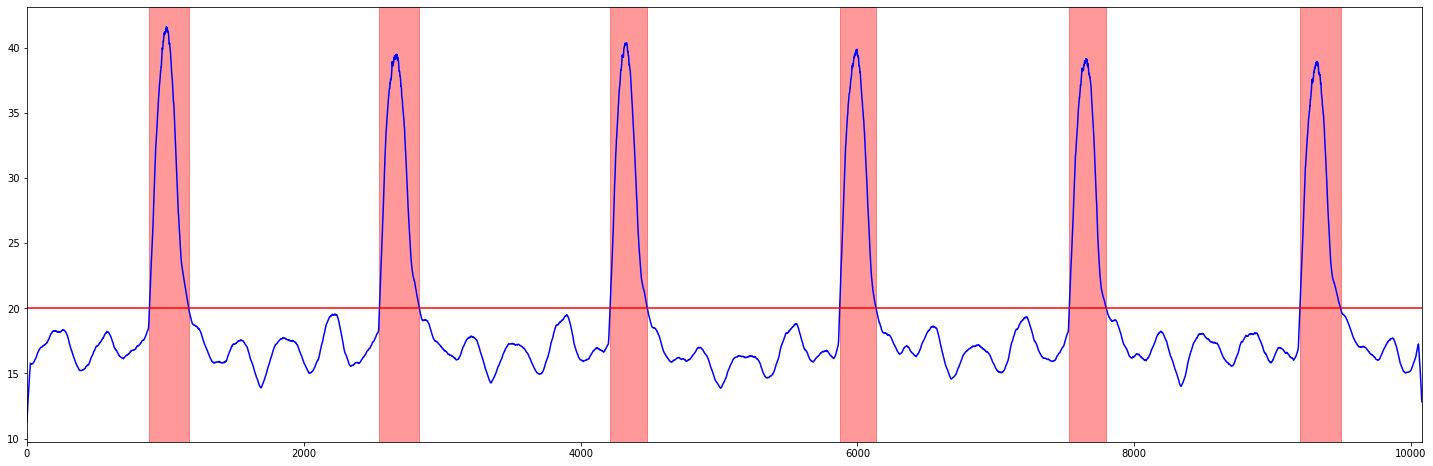

In [86]:
##========================================
##繪出結果
plot_results( anomaly_score, plot_anomaly_score = True)